In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display_html
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from statsmodels.stats.multicomp import MultiComparison

sns.set()

%matplotlib inline

import tjse

## Experimento 1

In [2]:
experimento1 = tjse.carregar_dados_experimento1()

experimento1.head()

,Chave,TUD,Stemmer,Coleção
0,201100200560443632531,576,NoStem,Segundo Grau - Acórdãos
1,201100200560443632531,517,Porter,Segundo Grau - Acórdãos
2,201100200560443632531,480,RSLP,Segundo Grau - Acórdãos
3,201100200560443632531,540,RSLP-S,Segundo Grau - Acórdãos
4,201100200560443632531,535,UniNE,Segundo Grau - Acórdãos


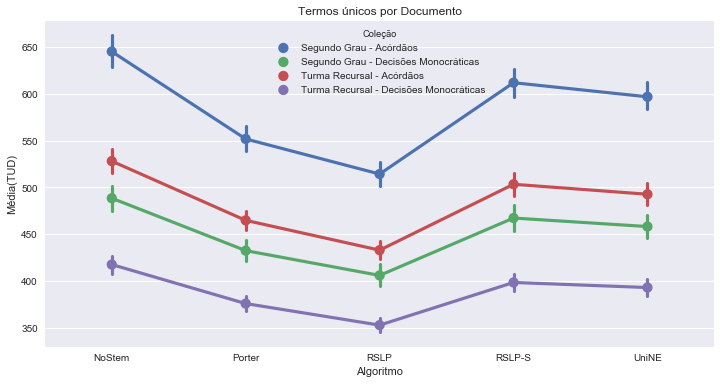

In [3]:
plt.figure(figsize=(12, 6))
graph1 = sns.pointplot(x="Stemmer", y="TUD", hue="Coleção",
                 data=experimento1, n_boot=1000)
graph1.set_ylabel('Média(TUD)')
graph1.set_xlabel('Algoritmo')
graph1.set_title('Termos únicos por Documento')
plt.show()

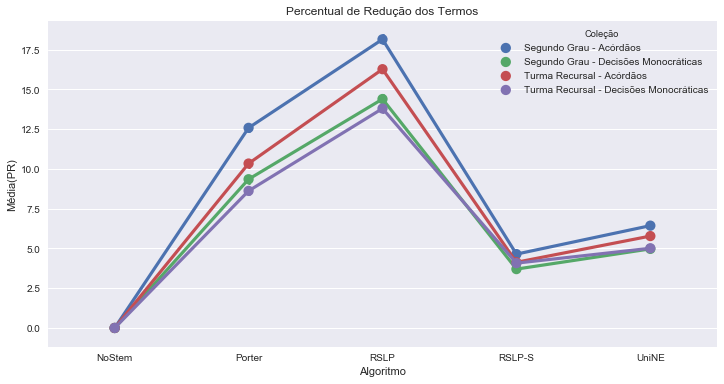

In [4]:
def percentual_de_reducao(dados):
    resultado = pd.pivot_table(dados, index=['Coleção', 'Chave'], columns='Stemmer', values='TUD') 
    
    resultado = resultado.assign(Porter = 100 - (resultado['Porter'] * 100) / resultado['NoStem'],
                                RSLPS = 100 - (resultado['RSLP-S'] * 100) / resultado['NoStem'],
                                RSLP = 100 - (resultado['RSLP'] * 100) / resultado['NoStem'],
                                UniNE = 100 - (resultado['UniNE'] * 100) / resultado['NoStem'],
                                NoStemTUD = resultado['NoStem'],
                                NoStem = 0.0)
    resultado.drop(['RSLP-S'], axis=1, inplace=True)
    resultado.rename(columns={'RSLPS': 'RSLP-S'}, inplace=True)
    
    return resultado

df_pr = percentual_de_reducao(experimento1)
df_graph = pd.melt(df_pr.reset_index(),
                   id_vars = ['Chave', 'Coleção'], 
                   value_vars=['NoStem','Porter','RSLP','RSLP-S','UniNE'], value_name='PR')
plt.figure(figsize=(12, 6))
graph2 = sns.pointplot(x="Stemmer", y="PR", hue="Coleção",
                 data=df_graph, n_boot=1000)
graph2.set_ylabel('Média(PR)')
graph2.set_xlabel('Algoritmo')
graph2.set_title('Percentual de Redução dos Termos')
plt.show()

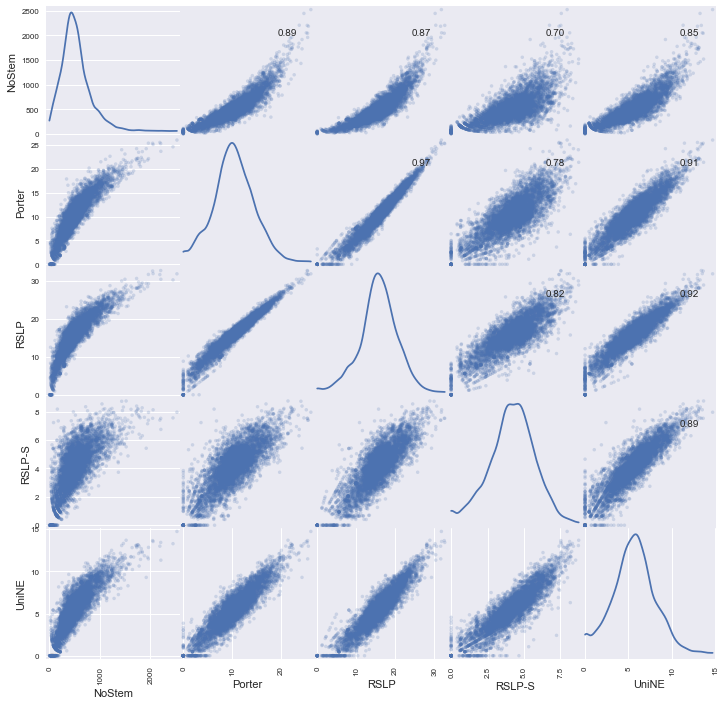

In [5]:
df_corr_graph = df_pr.drop(['NoStem'], axis=1).rename(columns={'NoStemTUD': 'NoStem'})
df_corr_graph = df_corr_graph[['NoStem', 'Porter', 'RSLP', 'RSLP-S', 'UniNE']]
axes = scatter_matrix(df_corr_graph, alpha=0.2, figsize=(12, 12), diagonal='kde')
corr = df_corr_graph.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

## Experimento 2

In [6]:
def carregar_dados_experimento2():
    colecoes = {
                'asg':'ASG',
                'dsg':'DSG',
                'atr':'ATR',
                'dtr': 'DTR'
               }
    algoritmos = {
                    'nostem':'NoStem', 
                    'porter' : 'Porter', 
                    'rslp' : 'RSLP',
                    'rslps' : 'RSLP-S', 
                    'unine' : 'UniNE'
                }
    metricas = {
            'map' : 'MAP', 
            'precR' : 'MPR', 
            'p10' : 'MPC'
            }
    
    dfs = []
    
    for colecao_chave, colecao_alias in colecoes.items():
        for algoritmo_chave, algoritmo_alias in algoritmos.items():
            for metrica_chave, metrica_alias in metricas.items():
                df = pd.read_csv('../csv/' + colecao_chave + "_" + algoritmo_chave + "_" + metrica_chave + ".csv", header=None, names = ['Qid', 'Valor'])
                df['Coleção'] =  colecao_alias
                df['Métrica'] = metrica_alias
                df['Stemmer'] = algoritmo_alias
                dfs.append(df)
    
    return pd.concat(dfs, axis = 0)

experimento2 = carregar_dados_experimento2()

experimento2.head()

,Qid,Valor,Coleção,Métrica,Stemmer
0,1,0.947681,ASG,MAP,NoStem
1,2,0.500000,ASG,MAP,NoStem
2,3,1.000000,ASG,MAP,NoStem
3,4,0.557677,ASG,MAP,NoStem
4,5,1.000000,ASG,MAP,NoStem


In [7]:
def bootstrap(values):
    valores = np.array([])
    for i in range(1000):
        valores = np.append(valores, np.random.choice(values, size=100, replace=True).mean())         
                    
    return valores

def plot_pairwise_tukeyhsd(colecao, metrica, grupos, grupos_labels):
    mc = MultiComparison(grupos, grupos_labels)
    result = mc.tukeyhsd()
    print(result)
    #Bug: https://github.com/statsmodels/statsmodels/issues/3584#issuecomment-289642981
    #fig = result.plot_simultaneous(comparison_name='NoStem')
    #fig.get_axes()[0].set_title('')

def plot_kde_normality(dados, col_name):
    colecao = dados.query('Coleção == @col_name')
    for metric in dados['Métrica'].unique():
        fig = plt.figure(figsize=(24, 16))
        grid = plt.GridSpec(2, 5, hspace=0.2, wspace=0.1)
        grupos = []
        grupos_labels = np.array([])
        df = colecao.query('Métrica == @metric')
        kde_ax = fig.add_subplot(grid[0, :])
        for i,stemmer in enumerate(df['Stemmer'].unique()):
            values = df.query("Stemmer == @stemmer")['Valor']
            values_bs = bootstrap(values)
            grupos.append(values_bs)
            grupos_labels = np.append(grupos_labels, np.repeat(stemmer, len(values_bs)))
            sns.kdeplot(values_bs, shade=True, ax = kde_ax)
            #Prability plot
            (osm, osr), (slope, intercept, r) = stats.probplot(values_bs)                
            ax_p = fig.add_subplot(grid[1, i])  
            line_color = kde_ax.get_lines()[i].get_color()                   
            ax_p.plot(osm, slope*osm + intercept, 'k-')
            ax_p.plot(osm, osr, 'o', color=line_color)            
            ax_p.set_title(stemmer)         
            ax_p.xaxis.set_ticks(np.linspace(-2,2,3))            
            ax_p.set_yticks(ax_p.get_yticks()[::3])     
            ax_p.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax_p.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            for spine in ax_p.spines.values():
                spine.set_visible(False)
            if i != 0:
                ax_p.set_ylabel('')
            else:
                ax_p.set_ylabel('Valores Ordenados')
            ax_p.set_xlabel('Quantis')
        
        plot_pairwise_tukeyhsd(col_name, metric, np.array(grupos).flatten(), grupos_labels)
            
        kde_ax.set_xlabel(metric)
        kde_ax.set_ylabel('Densidade de Probabilidade')
        kde_ax.set_xlim([0.5, 1])
        kde_ax.xaxis.get_major_ticks()[0].label1.set_visible(False)
        kde_ax.set_ylim([0, 30])
        kde_ax.yaxis.set_ticks(np.linspace(0,30,5))  
        kde_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        kde_ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))        
        for spine in kde_ax.spines.values():
                spine.set_visible(False)          

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0737  -0.0766 -0.0709  True 
NoStem  RSLP  -0.1971    -0.2  -0.1943  True 
NoStem RSLP-S  -0.021  -0.0238 -0.0181  True 
NoStem UniNE  -0.0501   -0.053 -0.0473  True 
Porter  RSLP  -0.1234  -0.1262 -0.1205  True 
Porter RSLP-S  0.0528   0.0499  0.0556  True 
Porter UniNE   0.0236   0.0207  0.0264  True 
 RSLP  RSLP-S  0.1761   0.1733  0.179   True 
 RSLP  UniNE   0.147    0.1441  0.1498  True 
RSLP-S UniNE  -0.0292   -0.032 -0.0263  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0892  -0.0918 -0.0865  True 
NoStem  RSLP  -0.2312  -0.2339 -0.2285  True 
NoStem RSLP-S -0.0284  -0.0311 -0.0257  True 
NoStem UniNE  -0.0661  -0.0688 -0.0635  True 
Porter  RSLP  -0.1421  -

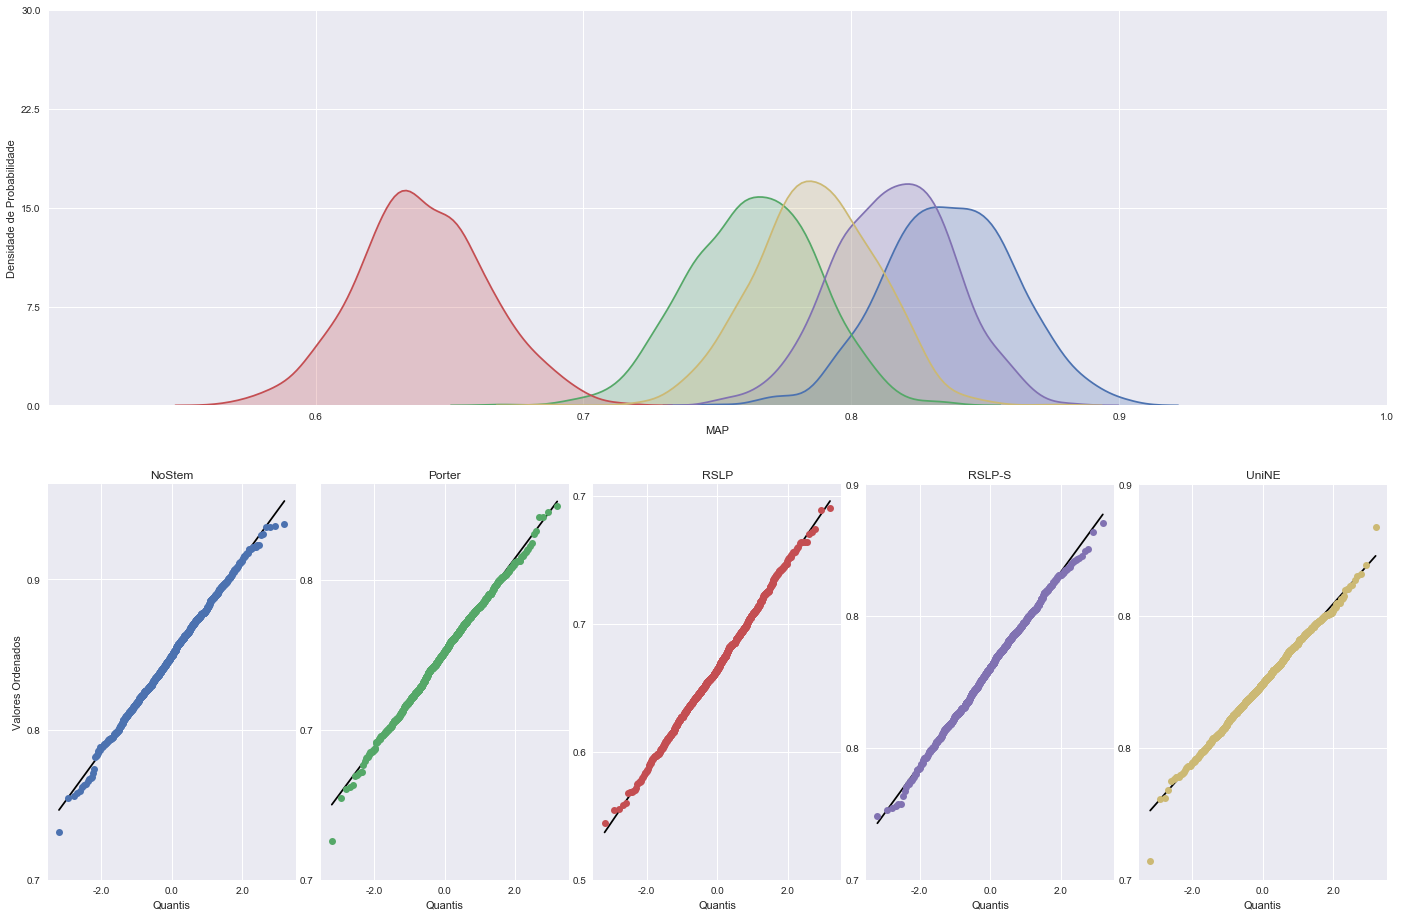

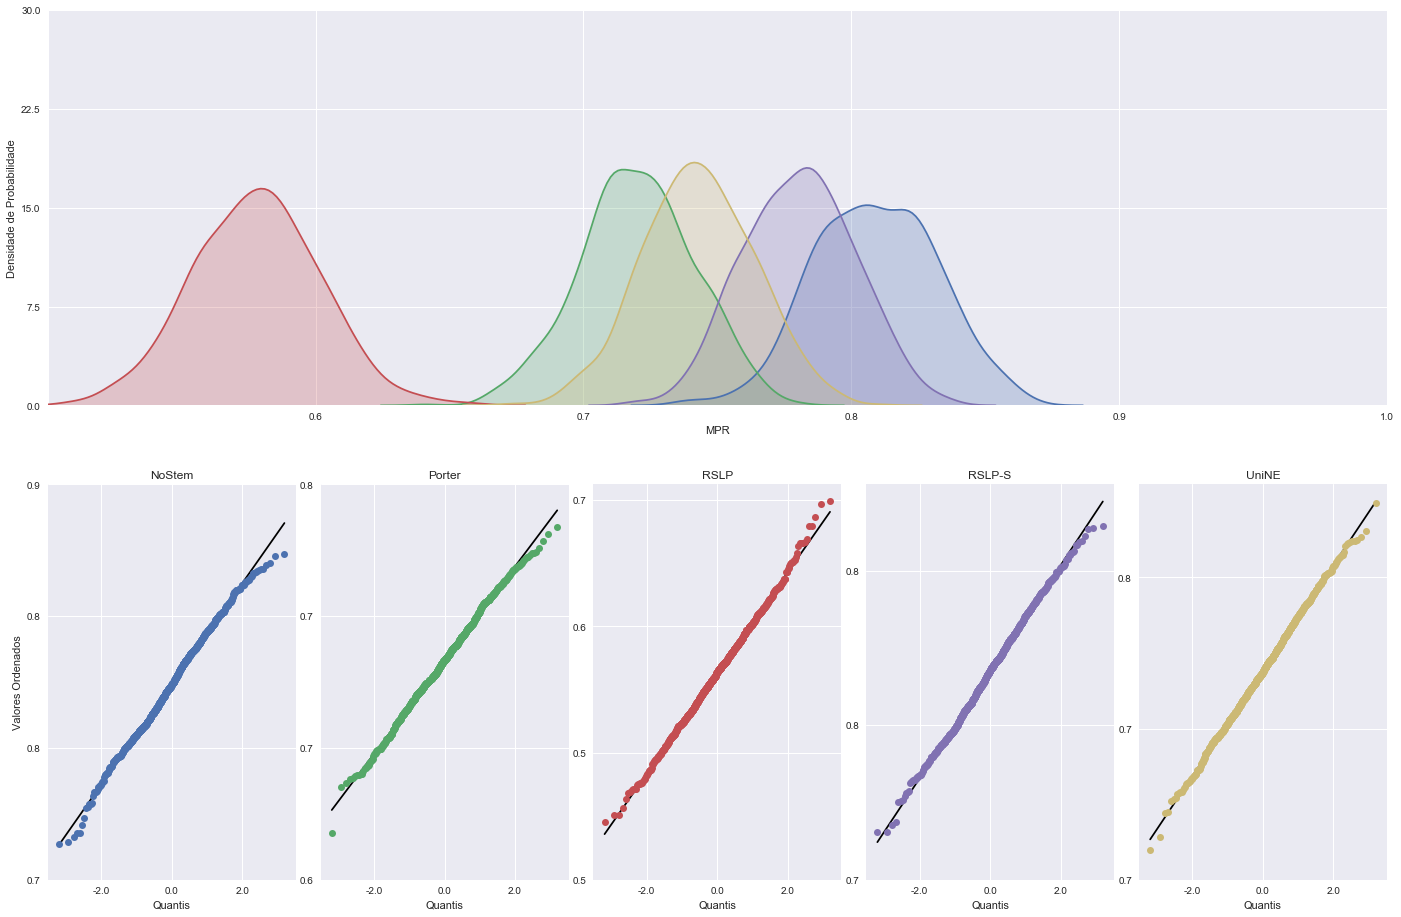

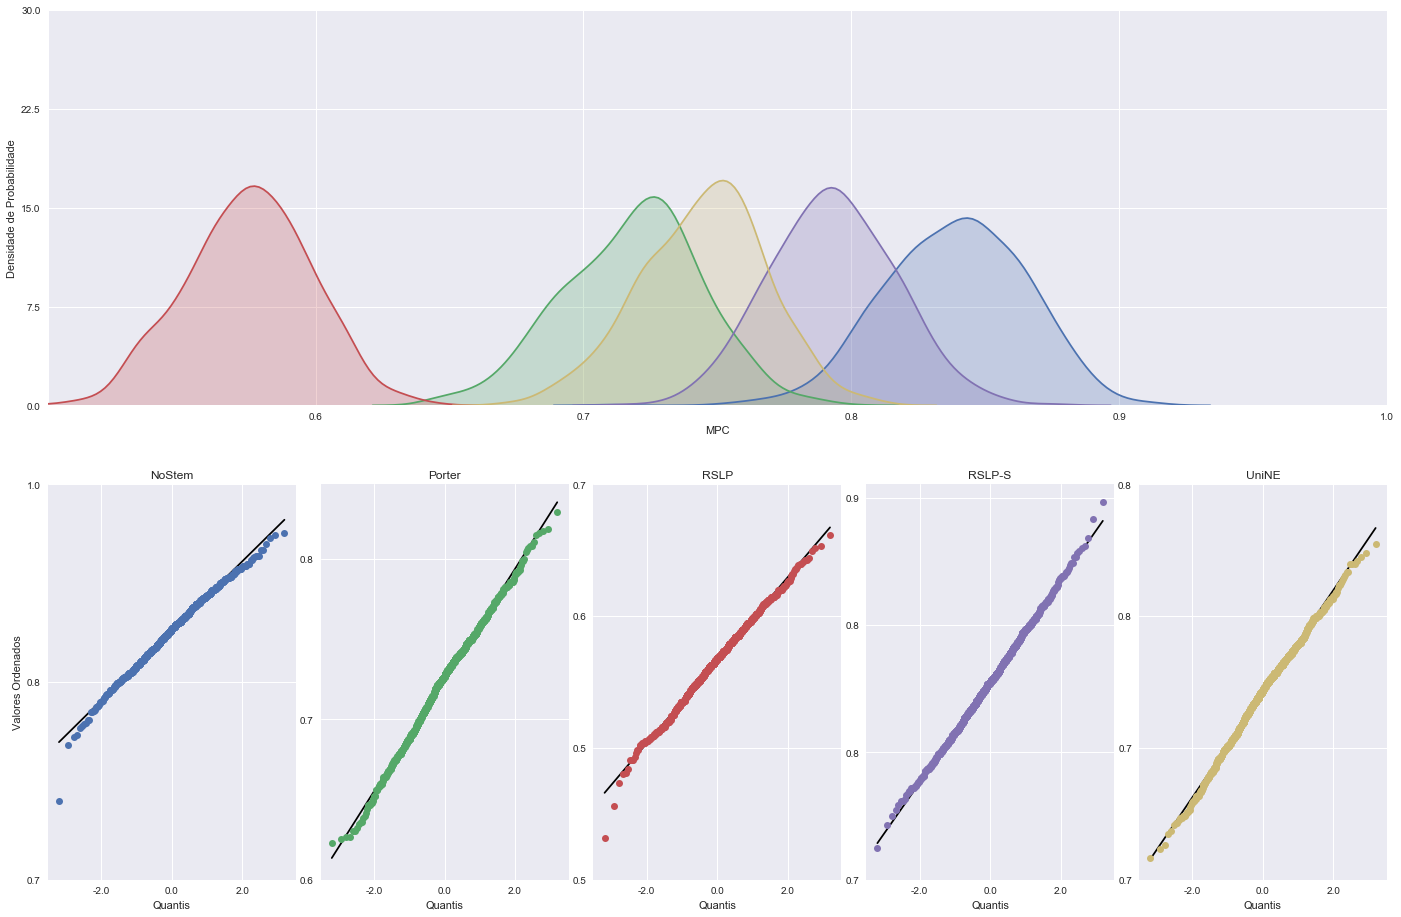

In [8]:
plot_kde_normality(experimento2, 'ASG')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0924  -0.0951 -0.0898  True 
NoStem  RSLP  -0.1782  -0.1809 -0.1756  True 
NoStem RSLP-S  -0.034  -0.0367 -0.0314  True 
NoStem UniNE   -0.013  -0.0156 -0.0103  True 
Porter  RSLP  -0.0858  -0.0884 -0.0832  True 
Porter RSLP-S  0.0584   0.0558  0.061   True 
Porter UniNE   0.0795   0.0768  0.0821  True 
 RSLP  RSLP-S  0.1442   0.1416  0.1468  True 
 RSLP  UniNE   0.1653   0.1626  0.1679  True 
RSLP-S UniNE   0.0211   0.0184  0.0237  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.1511  -0.1539 -0.1483  True 
NoStem  RSLP  -0.2322   -0.235 -0.2294  True 
NoStem RSLP-S -0.0509  -0.0537 -0.0482  True 
NoStem UniNE  -0.0402   -0.043 -0.0375  True 
Porter  RSLP  -0.0811  -

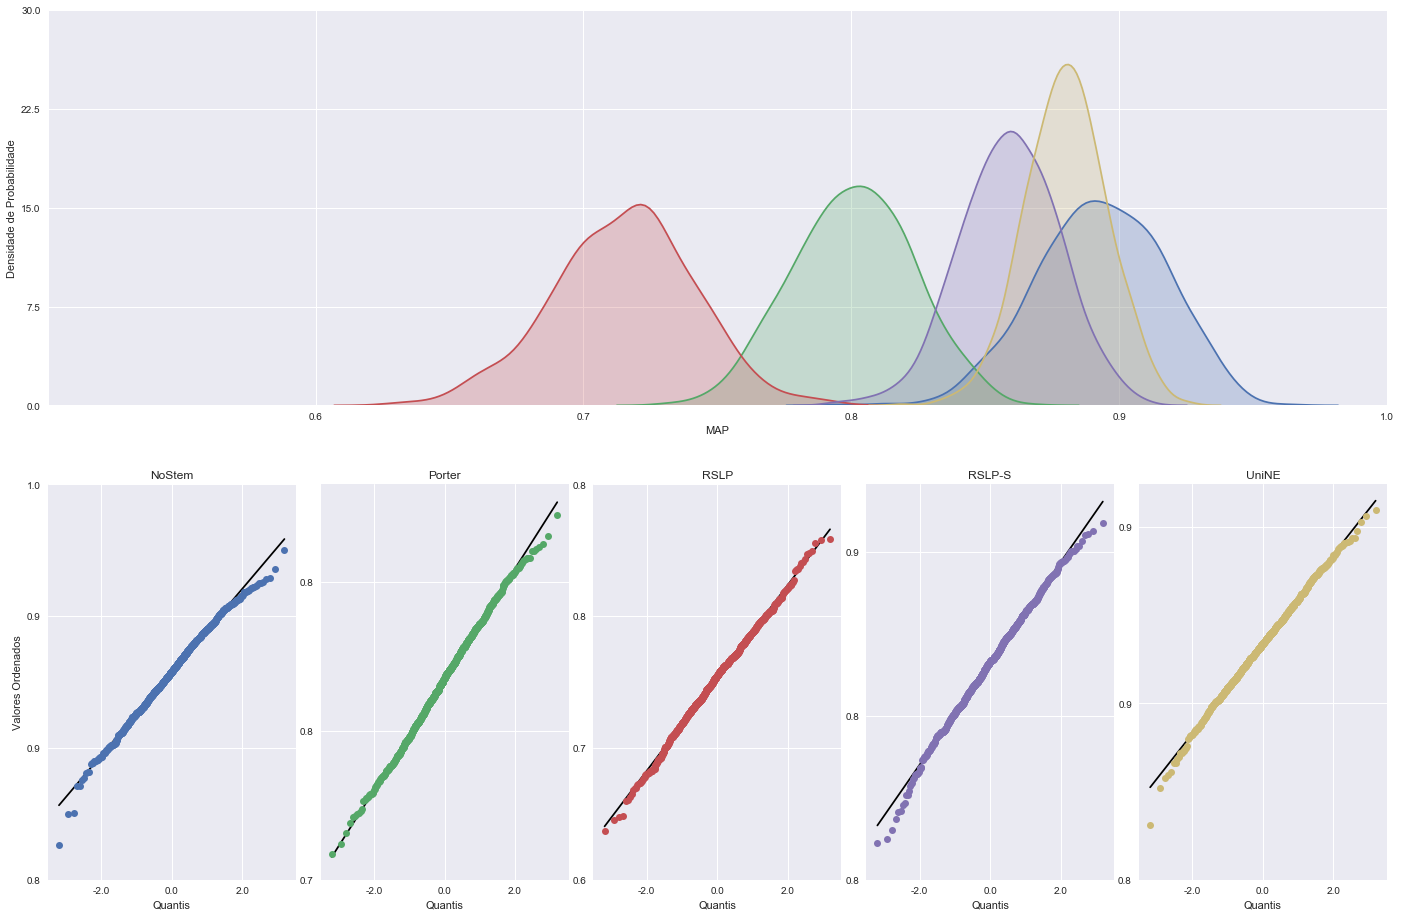

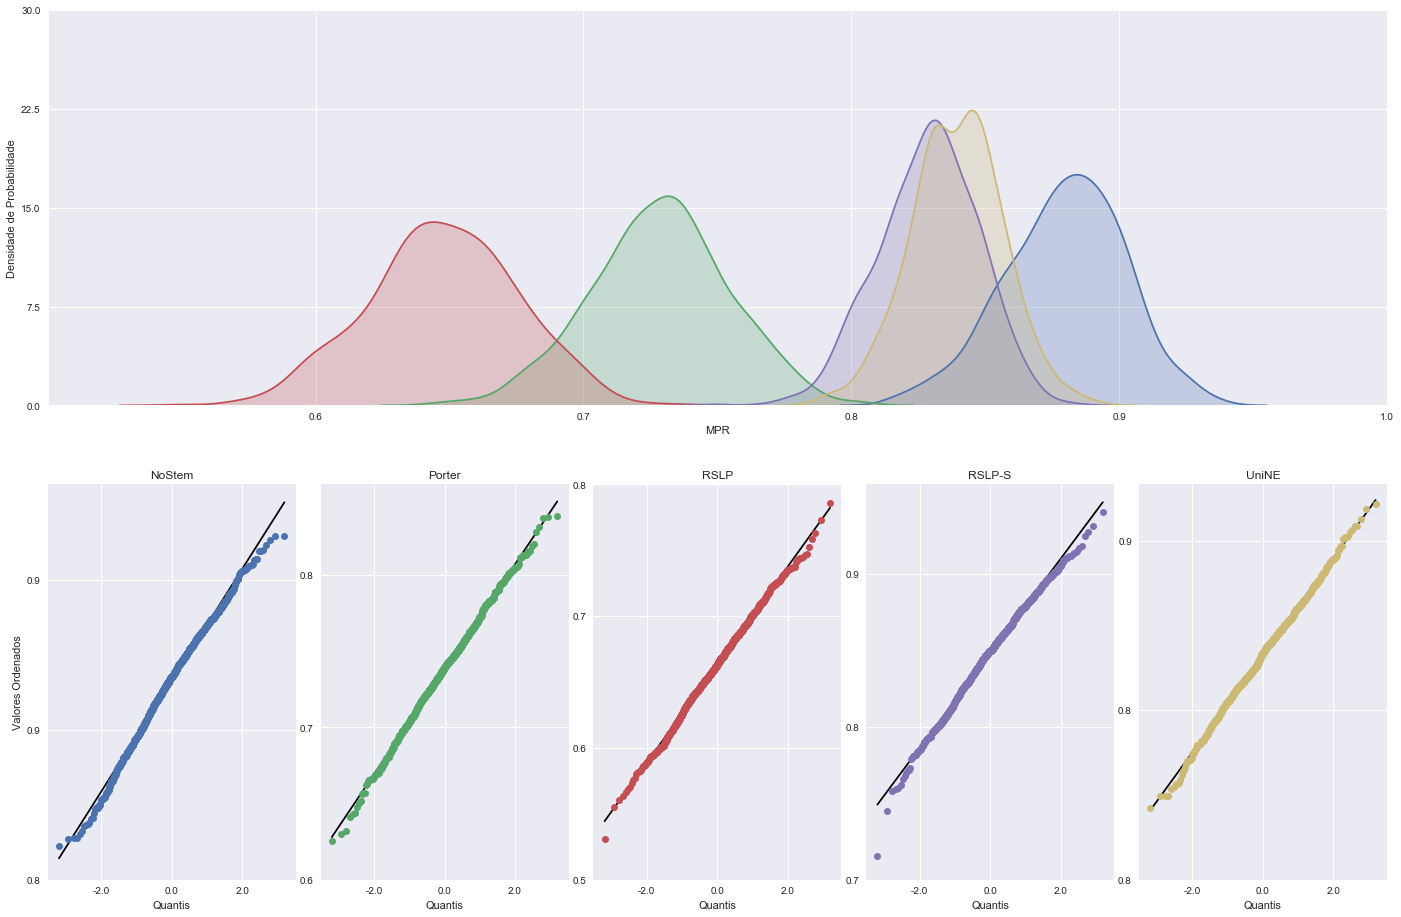

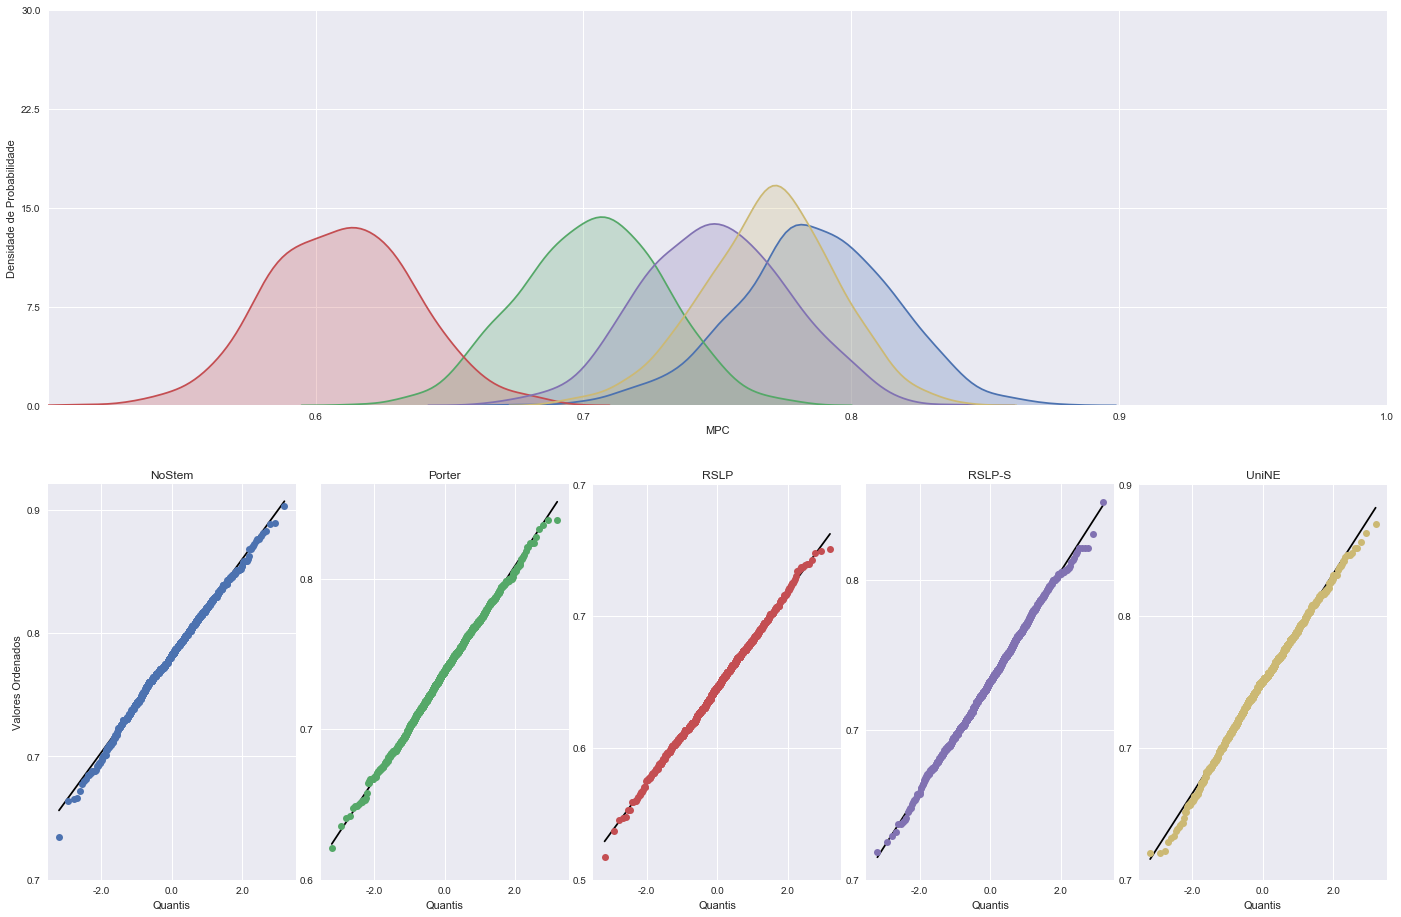

In [9]:
plot_kde_normality(experimento2, 'DSG')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0267  -0.0297 -0.0237  True 
NoStem  RSLP  -0.0471   -0.05  -0.0441  True 
NoStem RSLP-S  0.027    0.024   0.0299  True 
NoStem UniNE   0.0535   0.0506  0.0565  True 
Porter  RSLP  -0.0204  -0.0233 -0.0174  True 
Porter RSLP-S  0.0537   0.0507  0.0566  True 
Porter UniNE   0.0802   0.0773  0.0832  True 
 RSLP  RSLP-S  0.0741   0.0711  0.077   True 
 RSLP  UniNE   0.1006   0.0976  0.1035  True 
RSLP-S UniNE   0.0265   0.0236  0.0295  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0647  -0.0676 -0.0617  True 
NoStem  RSLP  -0.0965  -0.0995 -0.0936  True 
NoStem RSLP-S -0.0008  -0.0038  0.0021 False 
NoStem UniNE   0.0098   0.0069  0.0128  True 
Porter  RSLP  -0.0319  -

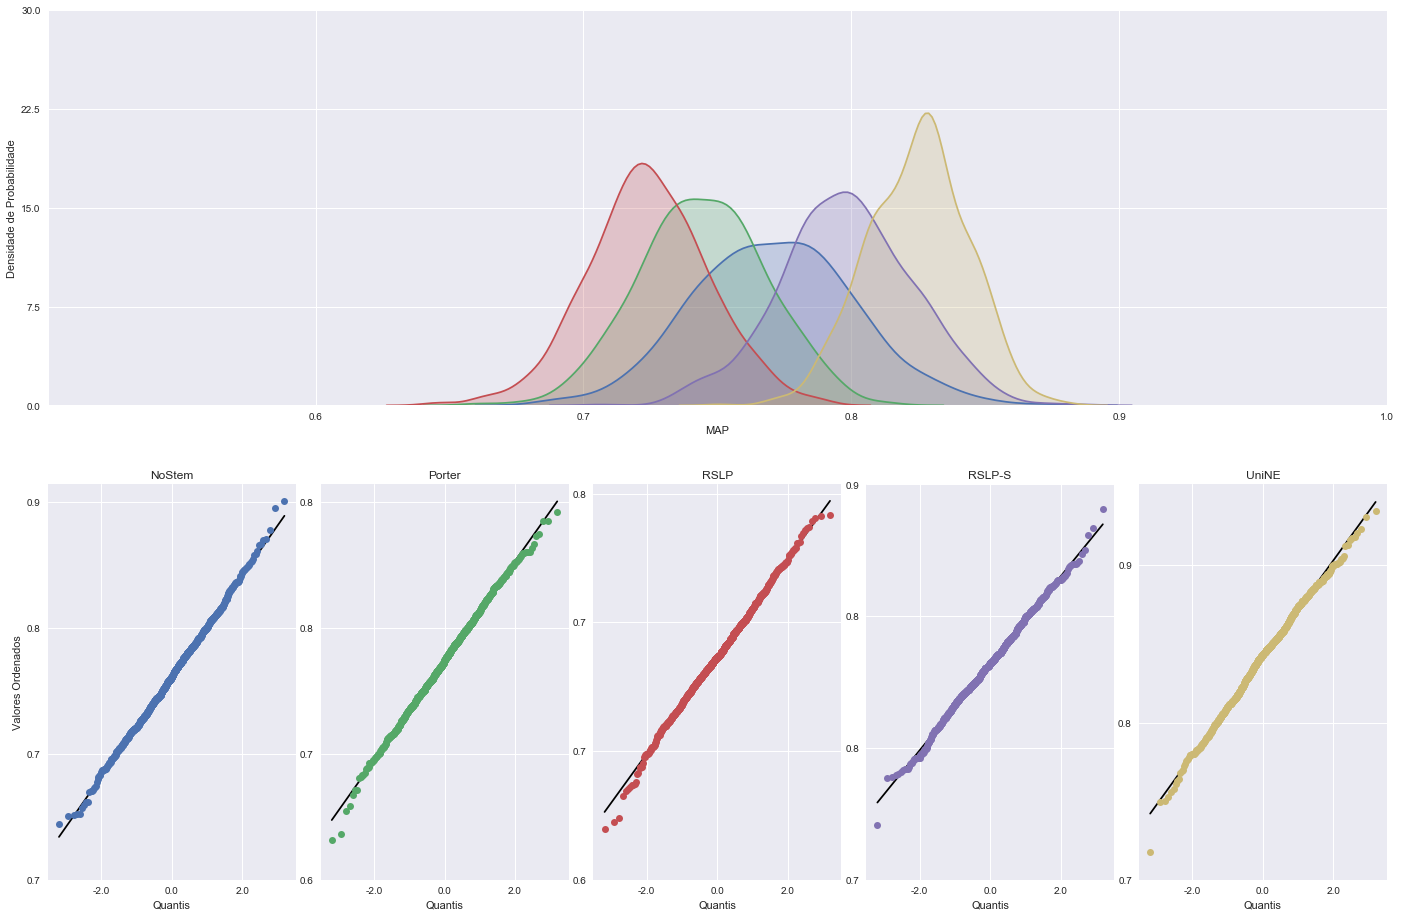

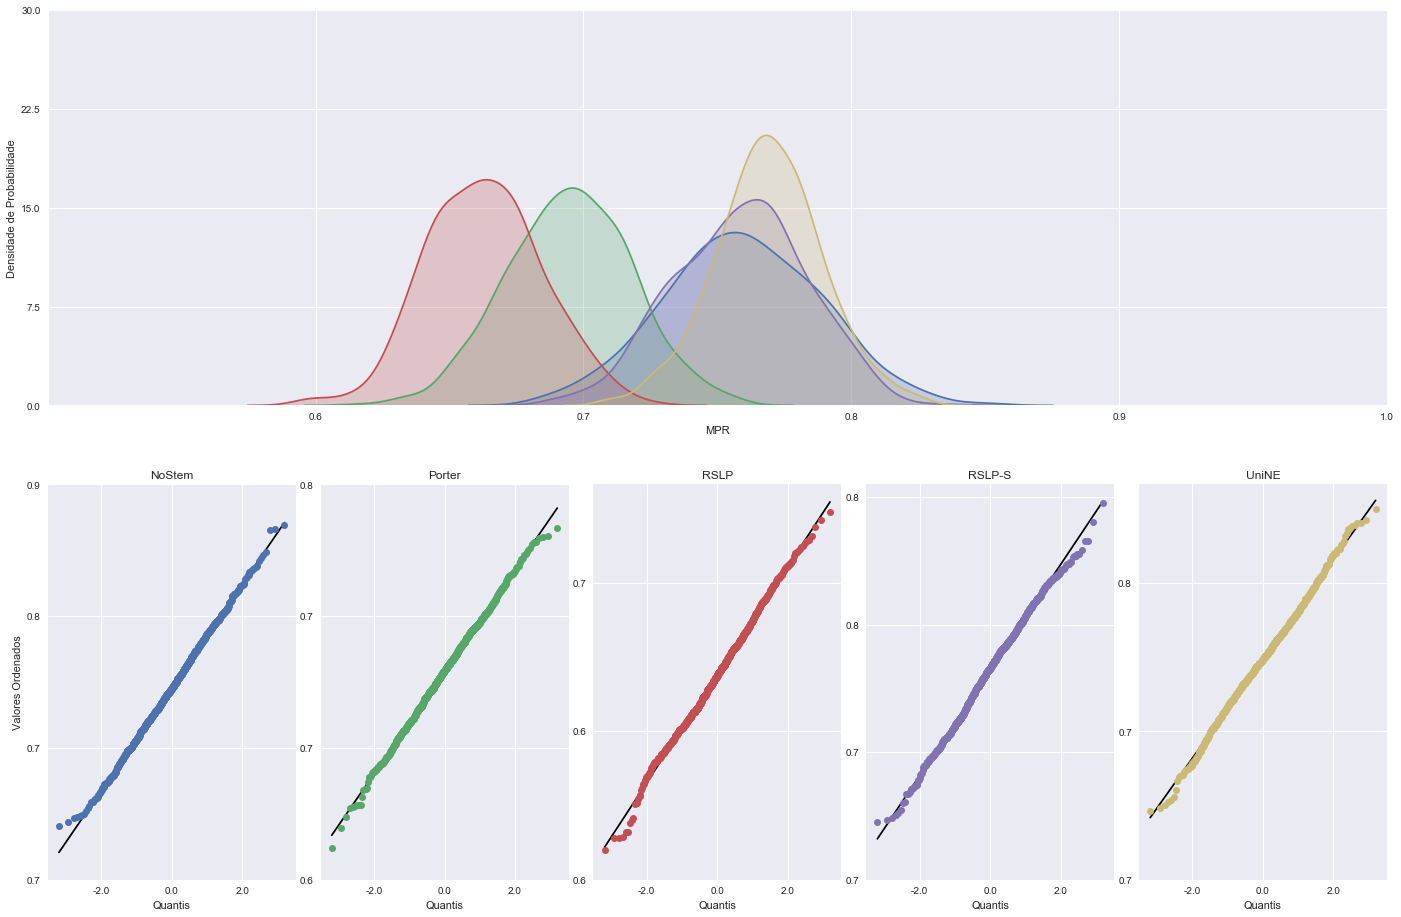

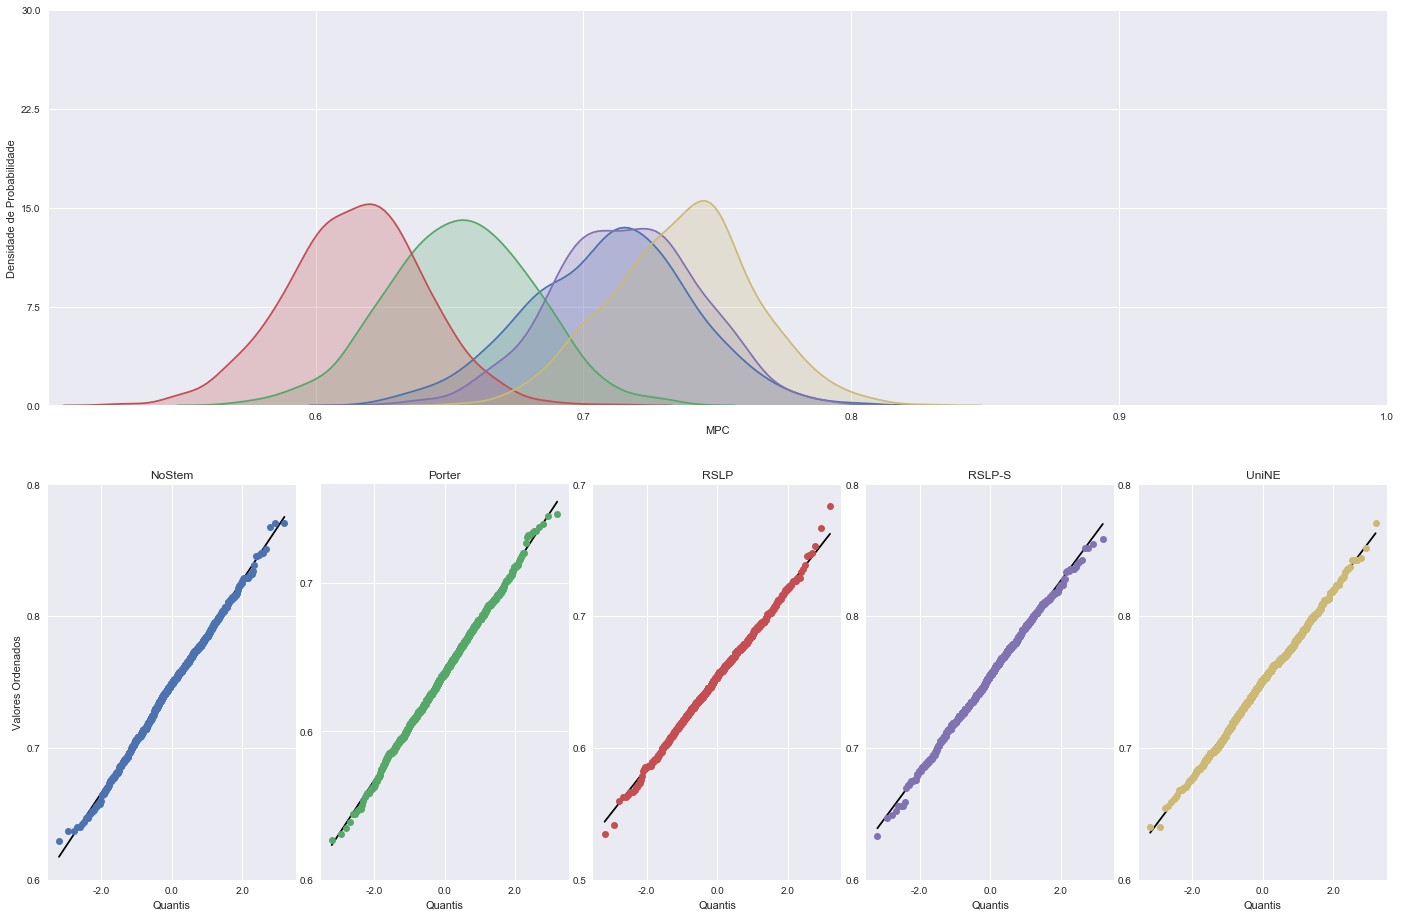

In [10]:
plot_kde_normality(experimento2, 'ATR')

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter  -0.011  -0.0136 -0.0084  True 
NoStem  RSLP  -0.1089  -0.1115 -0.1063  True 
NoStem RSLP-S -0.0041  -0.0067 -0.0014  True 
NoStem UniNE  -0.0207  -0.0233 -0.0181  True 
Porter  RSLP  -0.0979  -0.1005 -0.0953  True 
Porter RSLP-S  0.0069   0.0043  0.0095  True 
Porter UniNE  -0.0097  -0.0123 -0.0071  True 
 RSLP  RSLP-S  0.1048   0.1022  0.1075  True 
 RSLP  UniNE   0.0882   0.0856  0.0908  True 
RSLP-S UniNE  -0.0166  -0.0192  -0.014  True 
---------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
NoStem Porter -0.0447  -0.0474 -0.0419  True 
NoStem  RSLP  -0.1597  -0.1625  -0.157  True 
NoStem RSLP-S  -0.041  -0.0437 -0.0382  True 
NoStem UniNE  -0.0622  -0.0649 -0.0594  True 
Porter  RSLP   -0.115  -

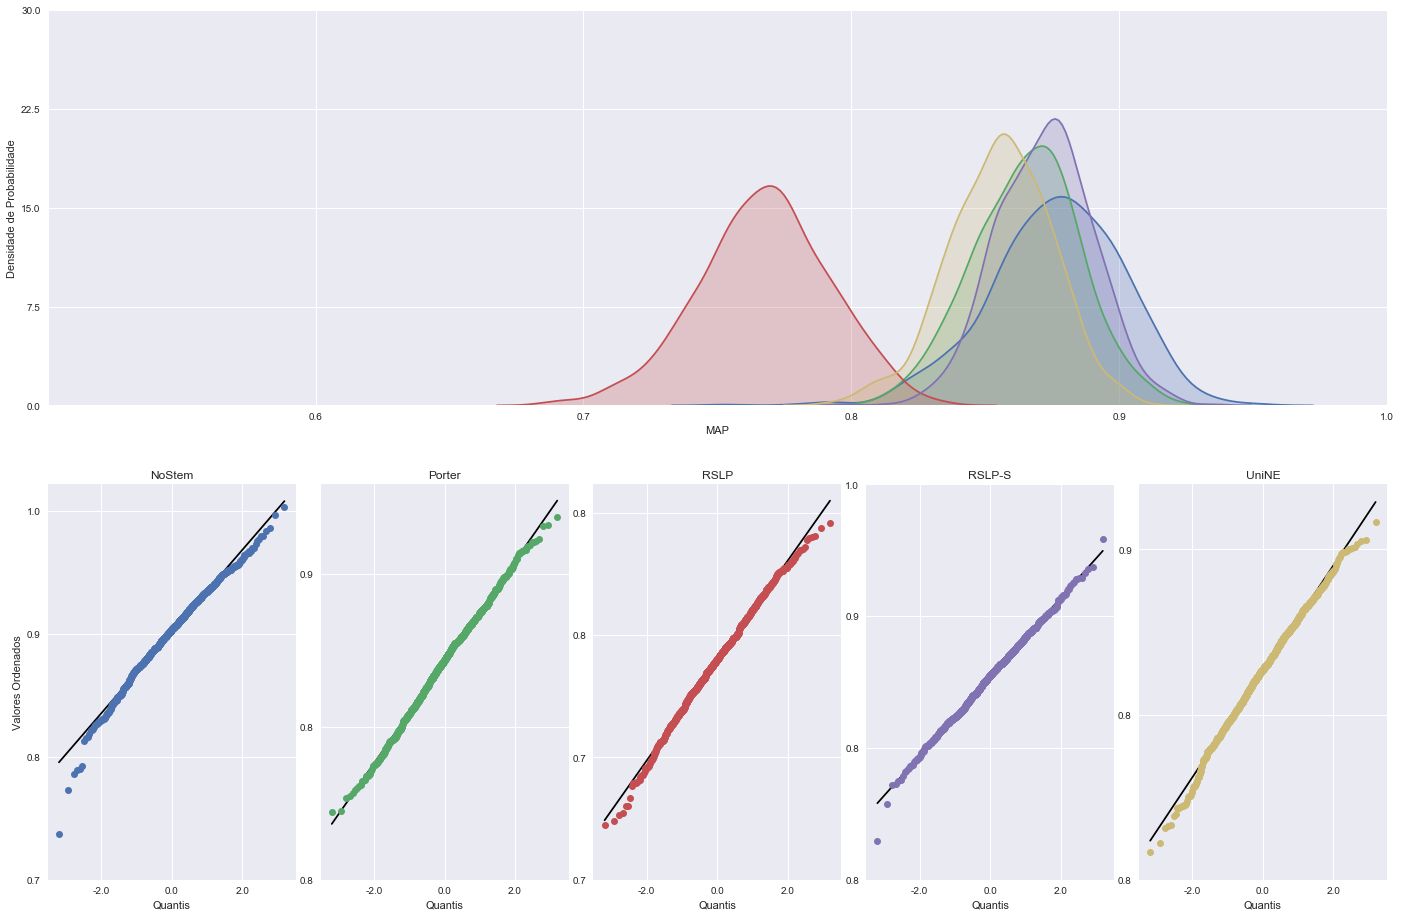

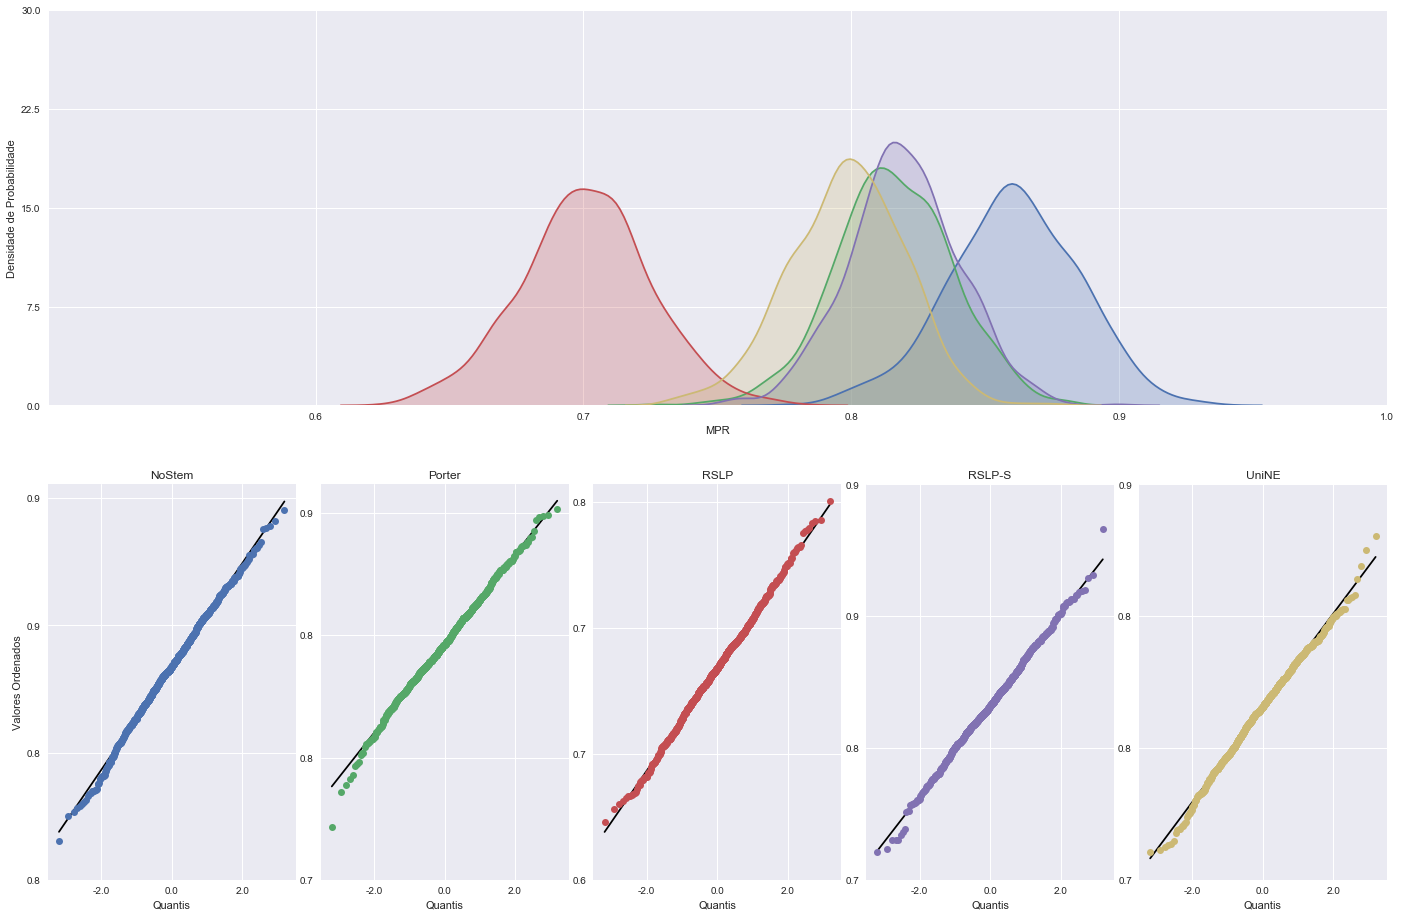

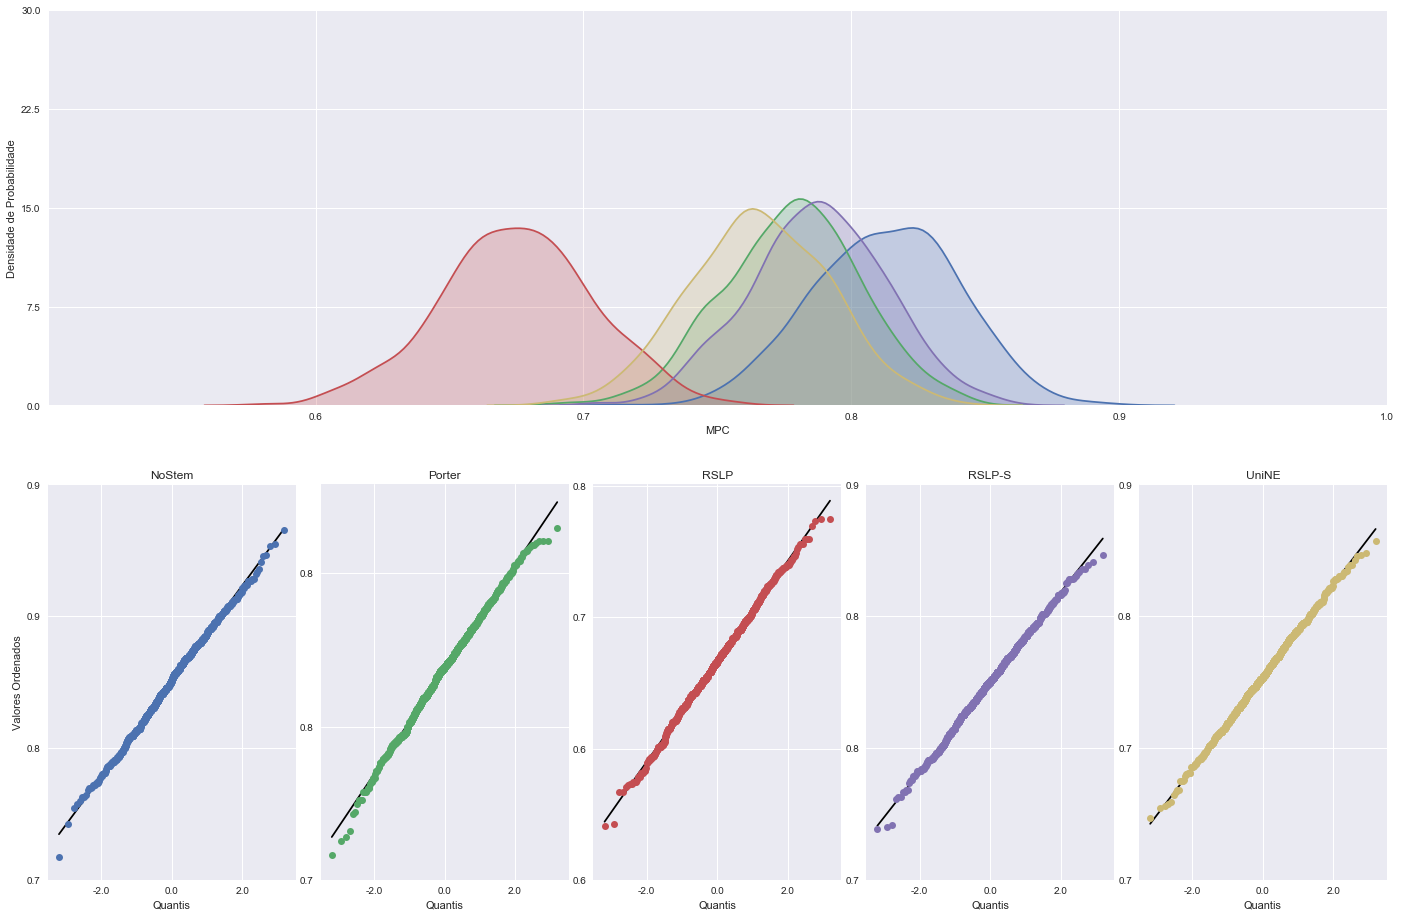

In [11]:
plot_kde_normality(experimento2, 'DTR')